# Controlled-Z Quantum Gate
          (Neutral Atom Quantum Gate Noisy Simulation)

> _Devesh Kumar          
> MSc Physics            
> IIT Roorkee_
  

## The C-Z Gate

This is a conditional gate that performs an Z-gate (phase flip) on the second qubit (target), if the state of the first qubit (control) is |1⟩.

Symbol of the C-NOT gate:
   
   <img src = 'cz.png' height = 150 width = 150 align = 'center'></img>

The unitary matrix operator of C-Z gate:
$$
U =
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

In the case of neutral atom realization of CZ gate, the ideal $U_{CZ}$ has the form

$$
U_{Ideal} =
\begin{bmatrix}
    -1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

with a global phase of $\pi$.


In [1]:
#Some imports from Pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

#Some general imports
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt
import qutip
from itertools import product

## Defining Register
The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $10\mu m$, named `C` and `T` for 'control' and 'target' respectively.

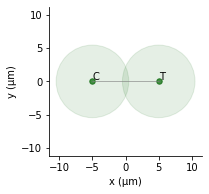

In [2]:
qubits = {'C': (-5,0) , 'T': (5,0) }

Omega_max = 2.3 * pi
blockade_radius = Chadoq2.rydberg_blockade_radius(pi)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)

## State preparation
This part of the sequence corresponds to preparing the different states on which the CZ gate will act. For this, we define the following Pulse instances that correspond to $\pi$ pulse.

In [3]:
#function that takes the label string of a state and turns it into a ket state

def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

State preparation sequence:

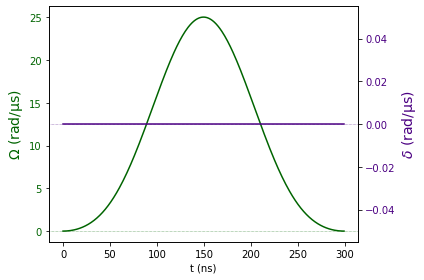

In [4]:
pi_wf = BlackmanWaveform(300, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

pi_y.draw()

In [5]:
def prep_seq(sid, reg):
    global seq
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq = Sequence(reg, Chadoq2)
    seq_dict = {'1':'T', '0':'C'}
    
    if sid == 'gg':
        basis = 'ground-rydberg'
        
    else:
        basis = 'all'
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(i)])
                else:
                    seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
            
    prep_state = state_prep(sid, basis)
            
    return prep_state

## Gate Sequence Preparation
We apply the three pulse $\pi-2\pi-\pi$ sequence for CZ gate. 

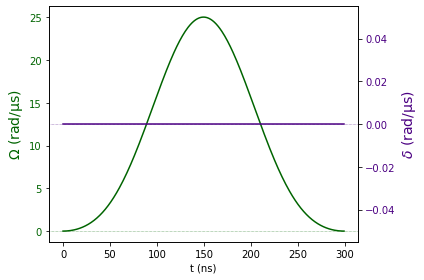

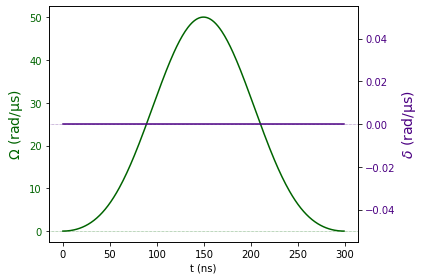

In [6]:
pi_wf = BlackmanWaveform(300, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

pi_pulse.draw()
twopi_pulse.draw()

In [7]:
def CZ_seq(int_id):
    
    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #Declare Rydberg channel
    seq.declare_channel('ryd', 'rydberg_local', 'C')
    
    #CZ sequence:
    seq.add(pi_pulse, 'ryd', 'wait-for-all')  # Wait for state preparation to finish.
    seq.target('T', 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target('C', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')
    
    return prep_state, prep_time

### Visualising sequence



 Visualization for the initial state '10': 




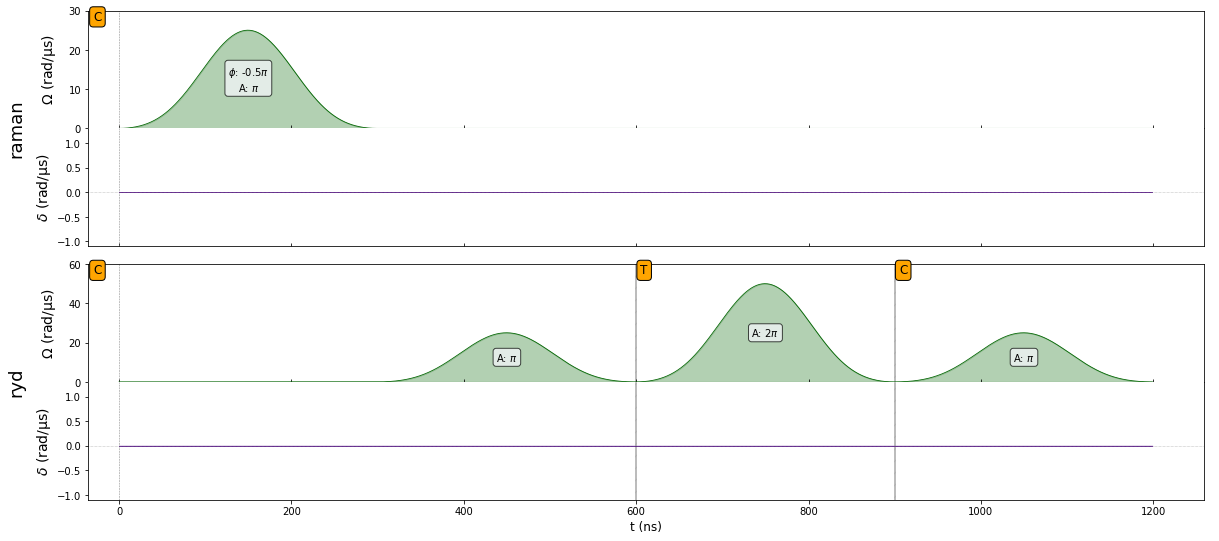


 Prepared state --> Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

 Preparation time: 300ns 


Channel: raman
t: 0 | Initial targets: C | Phase Reference: 0.0 
t: 0->300 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=4.71) | Targets: C

Channel: ryd
t: 0 | Initial targets: C | Phase Reference: 0.0 
t: 0->300 | Delay 
t: 300->600 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: C
t: 600->600 | Target: T | Phase Reference: 0.0
t: 600->900 | Pulse(Amp=Blackman(Area: 6.28), Detuning=0 rad/µs, Phase=0) | Targets: T
t: 900->900 | Target: C | Phase Reference: 0.0
t: 900->1200 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: C




In [8]:
print(f"\n\n Visualization for the initial state '10': \n\n")
prep_state, prep_time = CZ_seq('eg')
seq.draw(draw_phase_area=True)
print(f'\n Prepared state --> {prep_state}')
print(f'\n Preparation time: {prep_time}ns \n\n')
print(seq)

## Simulating the CZ-Sequence
We've introduce SPAM and Doppler damping errors with parameters `eta`: 0.02, `epsilon`: 0.01, and `epsilon_prime`: 0.05

1) eg 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]] Prep time: 300
 conts: Counter({'10': 913, '00': 78, '11': 8, '01': 1})



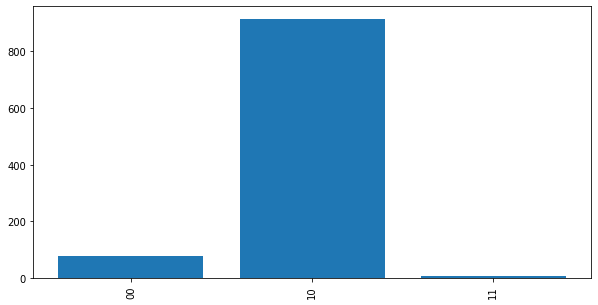

2) ee 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]] Prep time: 600
 conts: Counter({'11': 889, '01': 64, '10': 47})



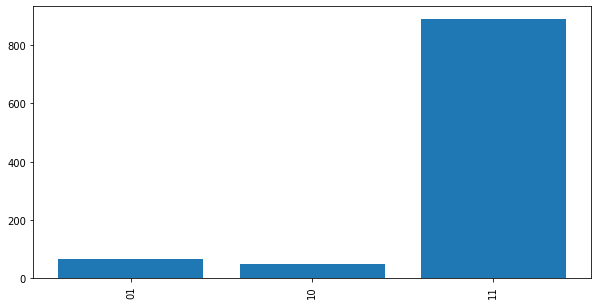

3) gg 
 Prep state:Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]] Prep time: 0
 conts: Counter({'00': 979, '01': 12, '10': 9})



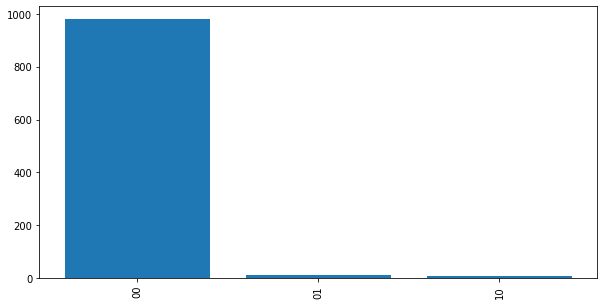

4) ge 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]] Prep time: 300
 conts: Counter({'01': 917, '00': 70, '11': 11, '10': 2})



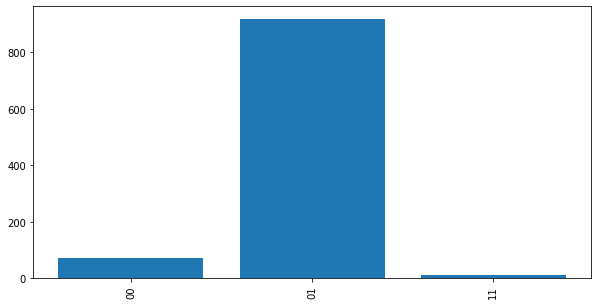

In [9]:
n=1

for sid in {'gg', 'eg','ge','ee'}:
    # Get CZ sequence
    prep_state, prep_time = CZ_seq(sid) # constructs seq, prep_state and prep_time
    
    # Construct Simulation instance
    sim = Simulation(seq)
    cfg = SimConfig(noise=('SPAM', 'doppler'), eta = 0.02, temperature = 100, runs = 1000) 
    sim.set_config(cfg)

    res = sim.run()
    
    count = res.sample_final_state(N_samples=1e3)
    
    print(f'{n}) {sid} \n Prep state:{prep_state} Prep time: {prep_time}\n conts: {count}\n')

    most_freq = {k:v for k,v in count.items() if v>5}
    
    plt.figure(figsize=(10,5))
    plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
    plt.xticks(rotation ='vertical')
    plt.show()
    n +=1 
    

## Analysis



### Probability matrix

We can extract the probability matrix of Controlled-Z quantum gate using the graphs above, obtained from the simulation as follows


$$
U_{CZ} =
\begin{bmatrix}
    0.979 & 0.012 & 0.009 & 0.000 \\
    0.070 & 0.917 & 0.002 & 0.011 \\
    0.078 & 0.001 & 0.913 & 0.008 \\
    0.000 & 0.0064 & 0.047 & 0.889 \\
\end{bmatrix}
$$